In [48]:
import pandas as pd
import numpy as np

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import HeteroConv, GCNConv

class GraphSAGERecommender(nn.Module):
    def __init__(self, user_features, product_features, embedding_dim=64, hidden_dim=32):
        super(GraphSAGERecommender, self).__init__()
        
        # Input feature dimensions
        self.user_feature_dim = user_features.shape[1]
        self.product_feature_dim = product_features.shape[1]
        
        # First layer: transform node features into embeddings
        self.user_encoder = nn.Linear(self.user_feature_dim, embedding_dim)
        self.product_encoder = nn.Linear(self.product_feature_dim, embedding_dim)
        
        # GraphSAGE convolutional layers
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'product'): SAGEConv(embedding_dim, hidden_dim),
            ('product', 'rev_interacts', 'user'): SAGEConv(embedding_dim, hidden_dim)
        })
        
        self.conv2 = HeteroConv({
            ('user', 'interacts', 'product'): SAGEConv(hidden_dim, hidden_dim),
            ('product', 'rev_interacts', 'user'): SAGEConv(hidden_dim, hidden_dim)
        })
        
        # Final prediction layer
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x_dict, edge_indices_dict):
        # Initial embeddings from features
        x_dict['user'] = F.relu(self.user_encoder(x_dict['user']))
        x_dict['product'] = F.relu(self.product_encoder(x_dict['product']))
        
        # First message passing layer
        x_dict = self.conv1(x_dict, edge_indices_dict)
        x_dict = {key: F.relu(value) for key, value in x_dict.items()}
        
        # Second message passing layer
        x_dict = self.conv2(x_dict, edge_indices_dict)
        x_dict = {key: F.relu(value) for key, value in x_dict.items()}
        
        return x_dict
    
    def predict(self, user_emb, product_emb):
        # Concatenate user and product embeddings
        pair_emb = torch.cat([user_emb, product_emb], dim=1)
        # Predict interaction probability
        return torch.sigmoid(self.predictor(pair_emb))
# 

In [50]:
import torch.optim as optim
from torch_geometric.loader import LinkNeighborLoader


def train_model(model, data, epochs=100, lr=0.01, batch_size=64):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    # Split data into train/validation
    # (For simplicity, we're using all data for training in this example)
    # In a real scenario, you would use proper train/val/test splits
    
    # Use LinkNeighborLoader for link prediction tasks
    train_loader = LinkNeighborLoader(
        data,
        num_neighbors=[5] * 2, # Define neighbors for both hops, can adjust depth
        edge_label_index=(('user', 'interacts', 'product'), data['user', 'interacts', 'product'].edge_index),
        edge_label=data['user', 'interacts', 'product'].edge_attr, # Use edge weights as labels
        batch_size=batch_size,
        shuffle=True # Shuffle data for training
        # No input_nodes needed for LinkNeighborLoader when sampling links
    )
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        # Iterate over batches from LinkNeighborLoader
        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass: Get embeddings for nodes in the sampled subgraph
            # Note: batch.x_dict and batch.edge_index_dict contain the features and
            # connectivity of the sampled neighborhood subgraph.
            embeddings = model(batch.x_dict, batch.edge_index_dict)

            # Get user and product embeddings for the sampled edges (links)
            # batch[('user', 'interacts', 'product')].edge_label_index contains the node indices
            # *within the current batch* for the user-product pairs being predicted.
            user_idx, product_idx = batch[('user', 'interacts', 'product')].edge_label_index
            user_embs = embeddings['user'][user_idx]
            product_embs = embeddings['product'][product_idx]

            # Predict interactions for these pairs
            pred = model.predict(user_embs, product_embs).squeeze()

            # Ground truth - edge weights (labels) provided by LinkNeighborLoader
            target = batch[('user', 'interacts', 'product')].edge_label.float()

            # Compute loss
            # print(f'pred = {pred}') # Keep for debugging if needed
            # print(f'target = {target}') # Keep for debugging if needed
            loss = criterion(pred, target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        # Print progress
        if (epoch + 1) % 10 == 0:
            # print(total_loss)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [51]:
def get_recommendations(model, data, user_id, user_mapping, product_mapping, interactions_df, top_k=5):
    # Set model to evaluation mode
    model.eval()
    
    # Get index for the specified user ID
    user_idx = list(user_mapping.keys()).index(user_id)
    
    # Run model forward pass to get embeddings
    with torch.no_grad():
        embeddings = model(data.x_dict, data.edge_index_dict)
    
    # Get the embedding for our target user
    user_embedding = embeddings['user'][user_idx].unsqueeze(0)
    
    # Calculate scores for all products
    product_embeddings = embeddings['product']
    
    # For each product, calculate prediction score
    scores = []
    for prod_idx in range(len(product_mapping)):
        prod_embedding = product_embeddings[prod_idx].unsqueeze(0)
        score = model.predict(user_embedding, prod_embedding).item()
        product_id = list(product_mapping.keys())[prod_idx]
        scores.append((product_id, score))
    
    # Sort by score (descending) and get top-k
    scores.sort(key=lambda x: x[1], reverse=True)
    
    # Filter out products the user has already interacted with
    existing_interactions = set(interactions_df[interactions_df['user_id'] == user_id]['product_id'])
    recommendations = [(prod_id, score) for prod_id, score in scores if prod_id not in existing_interactions][:top_k]
    
    return recommendations

In [52]:
from faker import Faker

def prepare_data(num_users=5, num_products=6, interaction_density=0.5):
    """
    Generates synthetic user-product interaction data using Faker.

    Args:
        num_users (int): Number of users to generate.
        num_products (int): Number of products to generate.
        interaction_density (float): Probability of a user-product interaction (0 to 1).

    Returns:
        interactions_df (pd.DataFrame): DataFrame of user-product interactions.
        users_df (pd.DataFrame): DataFrame of user features.
        products_df (pd.DataFrame): DataFrame of product features.
    """

    fake = Faker()

    # Generate Users
    users_data = []
    for i in range(num_users):
        user_id = f'U{i+1}'
        age = fake.random_int(min=18, max=60)
        preferred_category = fake.random_element(elements=('electronics', 'clothing', 'home_goods'))
        users_data.append({
            'user_id': user_id,
            'age': age,
            'preferred_category': preferred_category
        })
    users_df = pd.DataFrame(users_data)

    # Generate Products
    products_data = []
    categories = ['electronics', 'clothing', 'home_goods']
    for i in range(num_products):
        product_id = f'P{i+1}'
        name = fake.word().capitalize() + ' ' + fake.word().capitalize()
        category = fake.random_element(elements=categories)
        price = round(np.random.uniform(10, 1000), 2)  # Prices between 10 and 1000
        products_data.append({
            'product_id': product_id,
            'name': name,
            'category': category,
            'price': price
        })
    products_df = pd.DataFrame(products_data)

    # Generate Interactions
    interactions_data = []
    for _, user in users_df.iterrows():
        for _, product in products_df.iterrows():
            if np.random.rand() < interaction_density:
                interaction_type = fake.random_element(elements=('purchase', 'view'))
                weight = 1.0 if interaction_type == 'purchase' else 0.5
                interactions_data.append({
                    'user_id': user['user_id'],
                    'product_id': product['product_id'],
                    'interaction_type': interaction_type,
                    'weight': weight
                })
    interactions_df = pd.DataFrame(interactions_data)

    # Normalize numerical features
    products_df['price_normalized'] = products_df['price'] / products_df['price'].max()
    users_df['age_normalized'] = users_df['age'] / users_df['age'].max()

    # One-hot encode categorical features
    user_categories = pd.get_dummies(users_df['preferred_category'], prefix='prefers')
    users_df = pd.concat([users_df, user_categories], axis=1)

    product_categories = pd.get_dummies(products_df['category'], prefix='category')
    products_df = pd.concat([products_df, product_categories], axis=1)

    return interactions_df, users_df, products_df

def build_graph(interactions_df, users_df, products_df):
    import networkx as nx
    import torch
    from torch_geometric.data import HeteroData
    
    # Create a bipartite graph
    G = nx.Graph()
    
    # Add user nodes with features
    for _, user in users_df.iterrows():
        G.add_node(user['user_id'], 
                   type='user',
                   age=user['age_normalized'],
                   prefers_clothing=user['prefers_clothing'],
                   prefers_electronics=user['prefers_electronics'],
                   prefers_home_goods=user['prefers_home_goods'])
    
    # Add product nodes with features
    for _, product in products_df.iterrows():
        G.add_node(product['product_id'], 
                   type='product',
                   price=product['price_normalized'],
                   category_clothing=product['category_clothing'],
                   category_electronics=product['category_electronics'],
                   category_home_goods=product['category_home_goods'])
    
    # Add edges based on interactions
    for _, interaction in interactions_df.iterrows():
        G.add_edge(interaction['user_id'], interaction['product_id'], weight=interaction['weight'])
    
    # Preparing data for PyTorch Geometric
    user_mapping = {user_id: idx for idx, user_id in enumerate([n for n, d in G.nodes(data=True) if d['type'] == 'user'])}
    product_mapping = {prod_id: idx for idx, prod_id in enumerate([n for n, d in G.nodes(data=True) if d['type'] == 'product'])}
    
    edge_index = []
    edge_weights = []
    
    for u, v, data in G.edges(data=True):
        if G.nodes[u]['type'] == 'user':
            edge_index.append([user_mapping[u], product_mapping[v]])
        else:
            edge_index.append([user_mapping[v], product_mapping[u]])
        edge_weights.append(data['weight'])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)
    
    user_features = torch.tensor([[G.nodes[u]['age'], 
                                  G.nodes[u]['prefers_clothing'],
                                  G.nodes[u]['prefers_electronics'],
                                  G.nodes[u]['prefers_home_goods']] 
                                 for u in user_mapping], dtype=torch.float)
    
    product_features = torch.tensor([[G.nodes[p]['price'],
                                     G.nodes[p]['category_clothing'],
                                     G.nodes[p]['category_electronics'],
                                     G.nodes[p]['category_home_goods']] 
                                    for p in product_mapping], dtype=torch.float)
    
    data = HeteroData()
    data['user'].x = user_features
    data['product'].x = product_features
    
    # Add forward edges (user to product)
    data['user', 'interacts', 'product'].edge_index = edge_index
    data['user', 'interacts', 'product'].edge_attr = edge_weights
    
    # Add reverse edges (product to user)
    data['product', 'rev_interacts', 'user'].edge_index = torch.stack([edge_index[1], edge_index[0]], dim=0)
    data['product', 'rev_interacts', 'user'].edge_attr = edge_weights
    
    # Return all necessary objects
    return data, user_mapping, product_mapping, interactions_df, G

In [53]:
# Step 1: Prepare data
print("Preparing data...")
interactions_df, users_df, products_df = prepare_data(100, 50, 0.1)

# Step 2: Build graph
print("Building graph...")
data, user_mapping, product_mapping, interactions_df, G = build_graph(
    interactions_df, users_df, products_df
)

# Step 3: Create model
print("Creating model...")
model = GraphSAGERecommender(data['user'].x, data['product'].x)

# Step 4: Train model
print("Training model...")
model = train_model(model, data, epochs=100)

# Step 5: Generate recommendations for each user
print("\nGenerating recommendations:")
for user_id in user_mapping:
    recommendations = get_recommendations(
        model, data, user_id, user_mapping, product_mapping, interactions_df
    )
    
    # Display recommendations with product names
    # print(f"\nRecommendations for {user_id}:")
    for i, (prod_id, score) in enumerate(recommendations, 1):
        product_name = products_df.loc[products_df['product_id'] == prod_id, 'name'].values[0]
        # print(f"  {i}. {product_name} (score: {score:.4f})")

Preparing data...
Building graph...
Creating model...
Training model...
Epoch 10/100, Loss: 0.5513
Epoch 20/100, Loss: 0.5505
Epoch 30/100, Loss: 0.5512
Epoch 40/100, Loss: 0.5487
Epoch 50/100, Loss: 0.5423
Epoch 60/100, Loss: 0.5372
Epoch 70/100, Loss: 0.5410
Epoch 80/100, Loss: 0.5383
Epoch 90/100, Loss: 0.5302
Epoch 100/100, Loss: 0.5341

Generating recommendations:


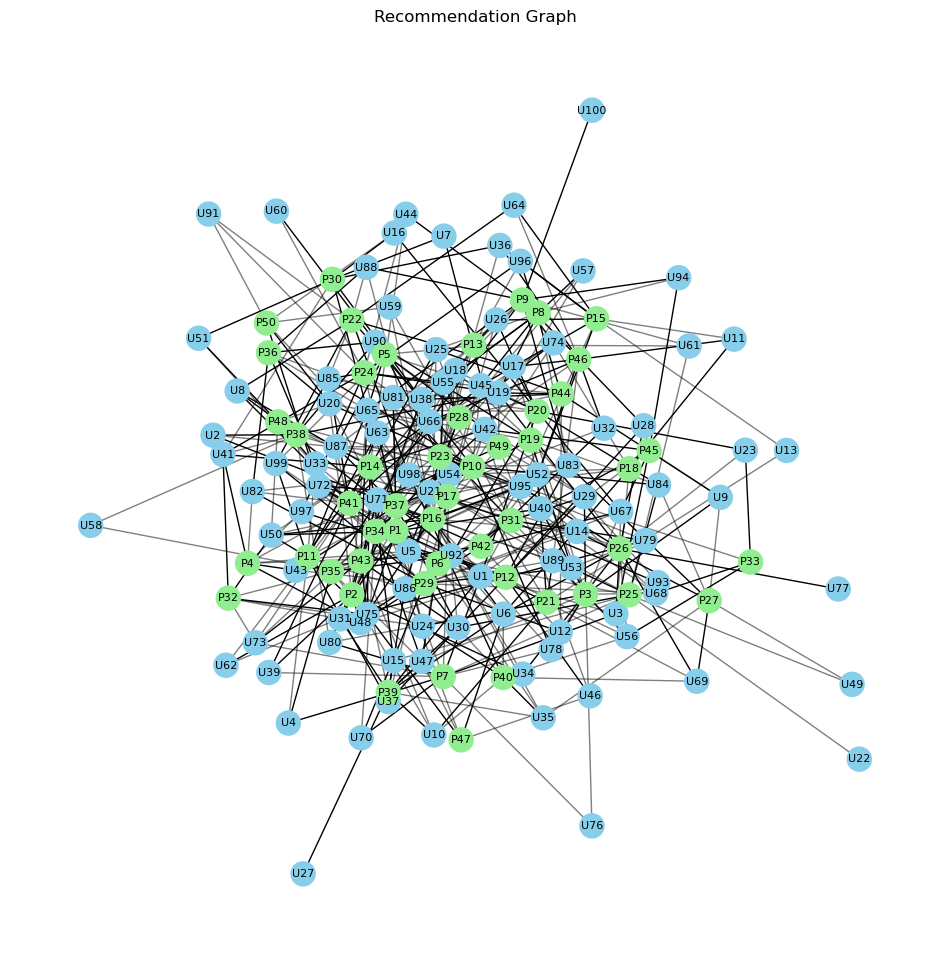

In [55]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your NetworkX graph
def visualize_graph(G):
    """
    Visualizes the graph G using matplotlib, differentiating edges by weight.
    """
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)  # You can use other layout algorithms
    
    # Node colors based on type
    node_colors = ['skyblue' if data['type'] == 'user' else 'lightgreen' for _, data in G.nodes(data=True)]
    
    # Edge weights and colors
    edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]
    
    # Normalize edge weights to a range between 0 and 1 for alpha values
    max_weight = max(edge_weights)
    normalized_weights = [w / max_weight for w in edge_weights]
    
    # Edge alphas based on normalized weights
    edge_alphas = normalized_weights
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors)
    
    # Draw edges with varying alpha (transparency) based on weight
    edges = nx.draw_networkx_edges(
        G,
        pos,
        width=1,
        alpha=edge_alphas,
    )
    
    # Node labels
    node_labels = {node: node for node in G.nodes()}  # Use IDs as labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    plt.title("Recommendation Graph")
    plt.axis('off')
    plt.show()    

# Call the function to visualize the graph
visualize_graph(G)